In [110]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [111]:
# Creating a SQL connection to our SQLite database
con = sqlite3.connect("../FPA_FOD_20210617.sqlite")

In [112]:
# Region dictionary
region_dict = {
    101:'Northeast Climate Region',
    102:'Upper Midwest Climate Region',
    103:'Ohio Valley Climate Region',
    104:'Southeast Climate Region',
    105:'Northern Rockies and Plains Climate Region',
    106:'South Climate Region',
    107:'Southwest Climate Region',
    108:'Northwest Climate Region',
    109:'West Climate Region'
}

In [113]:
# Querying the region_id, Discovery_date, FPA_ID from our "Fires" table
fire_data = pd.read_sql('SELECT region_id, DISCOVERY_DATE, FPA_ID FROM Fires', con).dropna()

In [114]:
# Printing the DataFrame
fire_data.head()

,region_id,DISCOVERY_DATE,FPA_ID
0,109.0,2/2/2005 0:00,FS-1418826
1,109.0,5/12/2004 0:00,FS-1418827
2,109.0,5/31/2004 0:00,FS-1418835
3,109.0,6/28/2004 0:00,FS-1418845
4,109.0,6/28/2004 0:00,FS-1418847


In [115]:
# Converting the "DISCOVERY_DATE" column to datetime
fire_data['DISCOVERY_DATE'] = pd.to_datetime(fire_data['DISCOVERY_DATE'])
fire_data.head()

,region_id,DISCOVERY_DATE,FPA_ID
0,109.0,2005-02-02,FS-1418826
1,109.0,2004-05-12,FS-1418827
2,109.0,2004-05-31,FS-1418835
3,109.0,2004-06-28,FS-1418845
4,109.0,2004-06-28,FS-1418847


In [116]:
# Casting the "DISCOVERY_DATE" to a datetime array - Months
# Counting the number of fires per region and discovery date
# Printing new DataFrame
period = fire_data.DISCOVERY_DATE.dt.to_period("M")
fire_data = fire_data.groupby([period, 'region_id']).count()
fire_data.head()

DISCOVERY_DATE  FPA_ID
DISCOVERY_DATE region_id                        
1992-01        101.0                  86      86
               102.0                   4       4
               103.0                 119     119
               104.0                2609    2609
               105.0                  86      86

In [117]:
# Renaming our "DISCOVERY_DATE" column
# Resetting the index
# Printing the updated DataFrame
fire_data.rename(columns={'DISCOVERY_DATE': 'Count'}, inplace=True)
fire_data = fire_data.reset_index()
fire_data.head()

,DISCOVERY_DATE,region_id,Count,FPA_ID
0,1992-01,101.0,86,86
1,1992-01,102.0,4,4
2,1992-01,103.0,119,119
3,1992-01,104.0,2609,2609
4,1992-01,105.0,86,86


In [118]:
# Adding a "Month" column
# Renaming our "DISCOVERY_DATE" column
# Printing the updated DataFrame
fire_data['Month'] = fire_data.iloc[:,0].dt.strftime('%m')
fire_data.rename(columns={'DISCOVERY_DATE':'Date'}, inplace=True)
fire_data.head()

,Date,region_id,Count,FPA_ID,Month
0,1992-01,101.0,86,86,01
1,1992-01,102.0,4,4,01
2,1992-01,103.0,119,119,01
3,1992-01,104.0,2609,2609,01
4,1992-01,105.0,86,86,01


In [119]:
# Renaming my "region_id" column
# Printing updated DataFrame
fire_data.rename(columns={'region_id': 'Region_id'}, inplace=True)
fire_data.head()

,Date,Region_id,Count,FPA_ID,Month
0,1992-01,101.0,86,86,01
1,1992-01,102.0,4,4,01
2,1992-01,103.0,119,119,01
3,1992-01,104.0,2609,2609,01
4,1992-01,105.0,86,86,01


In [120]:
# Querying the minimum temperatures, maximum temperatures and precipitation values from our Database and storing these into a DataFrame
weather_data = pd.read_sql('SELECT region_id, date, min_temp, max_temp,precipitation from weather', con).dropna()

In [121]:
# Converting the "date" column to datetime
# Printing the updated DataFrame
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.to_period("M")
weather_data.head()

,region_id,date,min_temp,max_temp,precipitation
0,101,1992-01,14.6,32.5,2.47
1,101,1992-02,16.5,34.9,2.22
2,101,1992-03,20.2,39.8,3.70
3,101,1992-04,32.8,53.1,2.74
4,101,1992-05,41.8,67.4,2.77


In [122]:
# Renaming my columns
# Printing updated DataFrame
weather_data.rename(columns={'region_id': 'Region_id'}, inplace=True)
weather_data.rename(columns={'date': 'Date'}, inplace=True)
weather_data.rename(columns={'min_temp': 'Mean_temp'}, inplace=True)
weather_data.rename(columns={'max_temp': 'Max_temp'}, inplace=True)
weather_data.rename(columns={'precipitation': 'Precipitation'}, inplace=True)
weather_data.head()

,Region_id,Date,Mean_temp,Max_temp,Precipitation
0,101,1992-01,14.6,32.5,2.47
1,101,1992-02,16.5,34.9,2.22
2,101,1992-03,20.2,39.8,3.70
3,101,1992-04,32.8,53.1,2.74
4,101,1992-05,41.8,67.4,2.77


In [123]:
# Merging the Fires and Weather tables
# Printing new DataFrame
merged_data = weather_data.merge(fire_data, how="left", on=["Date","Region_id"]).fillna(0)
merged_data.head()

,Region_id,Date,Mean_temp,Max_temp,Precipitation,Count,FPA_ID,Month
0,101,1992-01,14.6,32.5,2.47,86.0,86.0,01
1,101,1992-02,16.5,34.9,2.22,130.0,130.0,02
2,101,1992-03,20.2,39.8,3.70,283.0,283.0,03
3,101,1992-04,32.8,53.1,2.74,743.0,743.0,04
4,101,1992-05,41.8,67.4,2.77,830.0,830.0,05


In [124]:
# Creating a Deep Learning Model
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [129]:
# Casting the "Region_id", "Count" and "Month" columns into floats
merged_data = merged_data.astype({'Region_id':float,'Count':float,'Month':float})

In [5]:
# Assigning the data to X and y

X = data[["min_temp", "max_temp"]]
y = data["precipitation"].values.reshape(-1, 1)
print(X.shape, y.shape)

(2817, 2) (2817, 1)


In [6]:
# Using train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Creating the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [8]:
# Fitting the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.5912457931063698
Testing Score: 0.6018071123169637


Text(0.5, 1.0, 'plot')

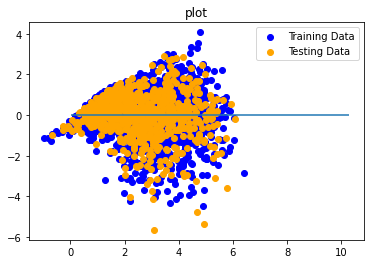

In [9]:
# Plotting the Training and Testing data

plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("plot")